# 🔥 Binary Prediction of Smoker Status using Bio-Signals and XGBoost
## Playground Series - Season 3, Episode 24
**According to a World Health Organization report, the number of deaths caused by smoking will reach 10 million by 2030.**


<img src="https://drive.google.com/uc?export=view&id=12R-zs-F0GsztmEAGj0PDK8Nur9b_OlZw" width="500px" height="500px">

**Notebook Strategy & Results of Experimentation**
* Configure the Notebook
* Load the Datasets and the Original Dataset **(Original dataset, helps quite a lot)**
* Explore the Information Loaded **(Data looks good nothing needed)**
* Clean and Transform the Data **(Nothing needed)**
* Create some Features
     * BMI **(Feature didn't add any value)**
     * Kmeans Features
         * Height (cm) **(Feature didn't add any value) -- Rank top among others...**
         * All Features **(Feature didn't add any value)**
     * I Created multiple ratio feature, basically all of them using a loop **(None of them make an improvement)**
     * Once I completed training the model I tried to use pseudolabeling **(model doesn't improve the CV core improve but not the LB score)**
* Feature Standarization
    * Robust **(Make the model worst)**
* Machine Learning Model
    * XGBoost Cross Validation **(I used a 5, 10 and 20 folds; The 10 is the best option so far)**
    * XGBoost Hyper Param Optimization **(Make the model worst from my manual calibration)**
* Model Submission



**About the Dataset**

Smoking has been proven to negatively affect health in a multitude of ways.Smoking has been found to harm nearly every organ of the body, cause many diseases, as well as reducing the life expectancy of smokers in general. As of 2018, smoking has been considered the leading cause of preventable morbidity and mortality in the world, continuing to plague the world’s overall health.

According to a World Health Organization report, the number of deaths caused by smoking will reach 10 million by 2030.

Evidence-based treatment for assistance in smoking cessation had been proposed and promoted. however, only less than one third of the participants could achieve the goal of abstinence. Many physicians found counseling for smoking cessation ineffective and time-consuming, and did not routinely do so in daily practice. To overcome this problem, several factors had been proposed to identify smokers who had a better chance of quitting, including the level of nicotine dependence, exhaled carbon monoxide (CO) concentration, cigarette amount per day, the age at smoking initiation, previous quit attempts, marital status, emotional distress, temperament and impulsivity scores, and the motivation to stop smoking. However, individual use of these factors for prediction could lead to conflicting results that were not straightforward enough for the physicians and patients to interpret and apply. Providing a prediction model might be a favorable way to understand the chance of quitting smoking for each individual smoker. Health outcome prediction models had been developed using methods of machine learning over recent years.

A group of scientists are working on predictive models with smoking status as the prediction target.Your task is to help them create a machine learning model to identify the smoking status of an individual using bio-signals

**Dataset Description**
* age : 5-years gap
* height(cm)
* weight(kg)
* waist(cm) : Waist circumference length
* eyesight(left)
* eyesight(right)
* hearing(left)
* hearing(right)
* systolic : Blood pressure
* relaxation : Blood pressure
* fasting blood sugar
* Cholesterol : total
* triglyceride
* HDL : cholesterol type
* LDL : cholesterol type
* hemoglobin
* Urine protein
* serum creatinine
* AST : glutamic oxaloacetic transaminase type
* ALT : glutamic oxaloacetic transaminase type
* Gtp : γ-GTP
* dental caries
* smoking


## Notebook Configuration...

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./EDA.ipynb
./efficient-prediction-of-smoker-status.ipynb
./test.csv
./origin_train_dataset.csv
./train.csv
./sample_submission.csv


In [2]:
from typing import Tuple
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss

import pandas as pd
from sklearn.ensemble import IsolationForest

In [3]:
%%time
# I like to disable my Notebook Warnings.
import warnings
warnings.filterwarnings('ignore')

# Configure notebook display settings to only use 2 decimal places, tables look nicer.
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 15) 
pd.set_option('display.max_rows', 50)

# Define some of the notebook parameters for future experiment replication.
SEED   = 0

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 34.1 µs


---

## Reading Datasets...

In [4]:
%%time
# Create a function to read the Datasets...
def read_datasets(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Reads train and test datasets from csv files and returns them as pandas DataFrames.

    Parameters:
    - train_path (str): The path to the train dataset csv file.
    - test_path (str): The path to the test dataset csv file.

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the train and test DataFrames.
    """

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    return train_df, test_df

# Usage:
train_path = './train.csv'
test_path = './test.csv'
train_df, test_df = read_datasets(train_path, test_path)

train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

train_df['is_original'] = 0
test_df['is_original'] = 0

CPU times: user 147 ms, sys: 48.1 ms, total: 195 ms
Wall time: 208 ms


In [5]:
# Merge the current train data with the original dataset...
original_path = './origin_train_dataset.csv'
original_df = pd.read_csv(original_path)
original_df['is_original'] = 1
train_df = pd.concat([train_df, original_df])

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198240 entries, 0 to 38983
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  198240 non-null  int64  
 1   height(cm)           198240 non-null  int64  
 2   weight(kg)           198240 non-null  int64  
 3   waist(cm)            198240 non-null  float64
 4   eyesight(left)       198240 non-null  float64
 5   eyesight(right)      198240 non-null  float64
 6   hearing(left)        198240 non-null  int64  
 7   hearing(right)       198240 non-null  int64  
 8   systolic             198240 non-null  int64  
 9   relaxation           198240 non-null  int64  
 10  fasting blood sugar  198240 non-null  int64  
 11  Cholesterol          198240 non-null  int64  
 12  triglyceride         198240 non-null  int64  
 13  HDL                  198240 non-null  int64  
 14  LDL                  198240 non-null  int64  
 15  hemoglobin           19

In [7]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

---

## Exploring Loading Information...

In [8]:
%%time
def analyze_dataframe(df):
    """
    Analyze a pandas DataFrame and provide a summary of its characteristics.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
    None
    """
    print("DataFrame Information:")
    print("----------------------")
    display(df.info(verbose=True, show_counts=True))
    print("\n")
    
    print("DataFrame Values:")
    print("----------------------")
    display(df.head(5).T)
    print("\n")

    print("DataFrame Description:")
    print("----------------------")
    display(df.describe().T)
    print("\n")

    print("Number of Null Values:")
    print("----------------------")
    display(df.isnull().sum())
    print("\n")

    print("Number of Duplicated Rows:")
    print("--------------------------")
    display(df.duplicated().sum())
    print("\n")

    print("Number of Unique Values:")
    print("------------------------")
    display(df.nunique())
    print("\n")

    print("DataFrame Shape:")
    print("----------------")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Usage
analyze_dataframe(train_df)

DataFrame Information:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 198240 entries, 0 to 38983
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  198240 non-null  int64  
 1   height(cm)           198240 non-null  int64  
 2   weight(kg)           198240 non-null  int64  
 3   waist(cm)            198240 non-null  float64
 4   eyesight(left)       198240 non-null  float64
 5   eyesight(right)      198240 non-null  float64
 6   hearing(left)        198240 non-null  int64  
 7   hearing(right)       198240 non-null  int64  
 8   systolic             198240 non-null  int64  
 9   relaxation           198240 non-null  int64  
 10  fasting blood sugar  198240 non-null  int64  
 11  Cholesterol          198240 non-null  int64  
 12  triglyceride         198240 non-null  int64  
 13  HDL                  198240 non-null  int64  
 14  LDL                  198240 

None



DataFrame Values:
----------------------


,0,1,2,3,4
age,55.000,70.000,20.000,35.000,30.000
height(cm),165.000,165.000,170.000,180.000,165.000
weight(kg),60.000,65.000,75.000,95.000,60.000
waist(cm),81.000,89.000,81.000,105.000,80.500
eyesight(left),0.500,0.600,0.400,1.500,1.500
eyesight(right),0.600,0.700,0.500,1.200,1.000
hearing(left),1.000,2.000,1.000,1.000,1.000
hearing(right),1.000,2.000,1.000,1.000,1.000
systolic,135.000,146.000,118.000,131.000,121.000
relaxation,87.000,83.000,75.000,88.000,76.000




DataFrame Description:
----------------------


,count,mean,std,min,25%,50%,75%,max
age,"198,240.000",44.271,11.886,20.000,40.000,40.000,55.000,85.000
height(cm),"198,240.000",165.153,8.896,130.000,160.000,165.000,170.000,190.000
weight(kg),"198,240.000",66.907,12.657,30.000,55.000,65.000,75.000,135.000
waist(cm),"198,240.000",82.817,9.039,51.000,77.000,83.000,89.000,129.000
eyesight(left),"198,240.000",1.008,0.423,0.100,0.800,1.000,1.200,9.900
eyesight(right),"198,240.000",1.003,0.414,0.100,0.800,1.000,1.200,9.900
hearing(left),"198,240.000",1.024,0.154,1.000,1.000,1.000,1.000,2.000
hearing(right),"198,240.000",1.024,0.153,1.000,1.000,1.000,1.000,2.000
systolic,"198,240.000",122.301,12.921,71.000,113.000,121.000,130.000,233.000
relaxation,"198,240.000",76.701,9.136,40.000,70.000,77.000,82.000,146.000




Number of Null Values:
----------------------


age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
is_original            0
dtype: int64



Number of Duplicated Rows:
--------------------------


5517



Number of Unique Values:
------------------------


age                     18
height(cm)              15
weight(kg)              29
waist(cm)              548
eyesight(left)          20
eyesight(right)         18
hearing(left)            2
hearing(right)           2
systolic               128
relaxation              94
fasting blood sugar    259
Cholesterol            279
triglyceride           393
HDL                    123
LDL                    286
hemoglobin             144
Urine protein            6
serum creatinine        34
AST                    196
ALT                    230
Gtp                    444
dental caries            2
smoking                  2
is_original              2
dtype: int64



DataFrame Shape:
----------------
Rows: 198240, Columns: 24
CPU times: user 163 ms, sys: 34.7 ms, total: 198 ms
Wall time: 202 ms


---

In [9]:
import pandas as pd

def remove_duplicates(df):
    """
    Remove duplicate rows from a DataFrame and print the number of duplicates found and removed.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - df_no_duplicates: DataFrame with duplicates removed
    """

    # Identify duplicates
    duplicates = df[df.duplicated()]

    # Print number of duplicates found and removed
    print(f"Number of duplicates found and removed: {len(duplicates)}")

    # Remove duplicates
    df_no_duplicates = df.drop_duplicates()

    return df_no_duplicates

train_df = remove_duplicates(train_df)

Number of duplicates found and removed: 5517


## Feature Engineering...


In [10]:
def create_features(df):
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
    df['HW_Ratio'] = df['height(cm)'] / df['waist(cm)']
    df['HA_Ratio'] = df['height(cm)'] / df['age']
    return df

#train_df = create_features(train_df)
#test_df = create_features(test_df)

In [11]:
def massive_feature(df, ignore_list):
    features = [feat for feat in df.columns if feat not in ignore_list]

    for idx1, col_one in enumerate(features):
        for idx2, col_two in enumerate(features):
            if idx1 < idx2:
                df[col_one +'_to_'+ col_two] = df[col_one] / df[col_two]
    return df

#train_df = massive_feature(train_df, ignore_list = ['id', 'smoking', 'is_original', 'dental caries','hearing(left)','hearing(right)',])
#test_df = massive_feature(test_df, ignore_list = ['id', 'smoking', 'is_original', 'dental caries','hearing(left)','hearing(right)',])

In [12]:
def count_outliers(df, features):
    # Subset the dataframe to only the specified features
    df_subset = df[features]
    
    # Initialize the Isolation Forest model
    clf = IsolationForest(contamination='auto')
    
    # Fit the model on the subset
    predictions = clf.fit_predict(df_subset)
    
    # Create a DataFrame to store the outlier count for each row
    outlier_count_df = pd.DataFrame({
        'Outlier_Count': [(pred == -1) for pred in predictions]
    })

    # Sum the counts for each row to get total outlier count
    total_outliers = outlier_count_df['Outlier_Count'].sum()
    
    # Attach the outlier count to the original dataframe
    df['Outlier_Count'] = outlier_count_df
    
    # Return the dataframe with the added outlier count column
    return df

# Example usage:
# Assuming 'df' is your dataframe and ['feature1', 'feature2'] are the features of interest
# df_with_outliers = count_outliers(df, ['feature1', 'feature2'])
# print(df_with_outliers)

ignore_list = ['id', 'smoking', 'is_original']
features = [feat for feat in train_df.columns if feat not in ignore_list]
train_df = count_outliers(train_df, features)
test_df = count_outliers(test_df, features)

---

## Selecting Model Features...

In [13]:
%%time
# Drop missing values target column of the dataset...
categorical_features = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
numerical_features = [feat for feat in train_df.columns if feat not in categorical_features and feat not in ['smoking']]

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 16.2 µs


In [14]:
def one_hot_encode(df, categorical_features):
    """
    One-hot encode the specified categorical features in the given DataFrame.

    Parameters:
    - df (pandas DataFrame): The input DataFrame.
    - categorical_features (list of str): List of categorical feature names to be one-hot encoded.

    Returns:
    - pandas DataFrame: A DataFrame with the specified categorical features one-hot encoded.
    """
    return pd.get_dummies(df, columns=categorical_features)

# train_df = one_hot_encode(train_df, categorical_features)
# test_df = one_hot_encode(test_df, categorical_features)

In [15]:
import pandas as pd
from sklearn.cluster import KMeans

def kmeans_features(df, features, n_clusters=3):
    """
    Adds new features to the DataFrame based on K-means clustering.
    
    Parameters:
    - df: pandas DataFrame.
    - features: List of features to use for clustering.
    - n_clusters: Number of clusters for K-means clustering (default is 3).
    
    Returns:
    - pandas DataFrame with new features based on the clustering.
    """
    # Extract the relevant features for clustering
    X = df[features]
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    
    # Create a new feature for the cluster labels
    df['cluster_label'] = kmeans.labels_
    
    # Add distance features for each cluster center
    for i, center in enumerate(kmeans.cluster_centers_):
        df[f'dist_to_center_{i}'] = ((X - center) ** 2).sum(axis=1) ** 0.5
        
    return df

# train_df = kmeans_features(train_df, numerical_features, 2)
# test_df = kmeans_features(test_df, numerical_features, 2)

In [16]:
%%time
model_features = [col for col in train_df.columns if col not in ['id', 
                                                                 'smoking',
                                                                 #'BMI',
                                                                 #'weight(kg)', 
                                                                 #'height(cm)'
                                                                ]]

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 14.1 µs


---

 ## Feature Standarization...

In [17]:
%%time
def standardize_features(df, features, method='zscore'):
    # Making a copy of the dataframe to avoid changing the original dataframe
    df_copy = df.copy()

    # Selecting the features to be standardized
    data_to_scale = df_copy[features]

    # Choosing the standardization method
    if method == 'zscore':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid method. Choose from 'zscore', 'minmax', or 'robust'.")

    # Applying the standardization
    standardized_data = scaler.fit_transform(data_to_scale)

    # Replacing the original feature values with the standardized values
    df_copy[features] = standardized_data

    return df_copy

# Usage
# train_df = standardize_features(train_df, model_features, method = 'robust')
# test_df = standardize_features(test_df, model_features, method = 'robust')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 2.86 µs


---

# Training an XGBoost Model...

In [18]:
model_features

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries',
 'is_original',
 'Outlier_Count']

# Optuna Hyper-Param Optimization

In [34]:


def objective(trial):
    # Load the dataset and split it into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(train_df[model_features], train_df['smoking'], test_size=0.25, random_state=SEED)

    # Define the hyperparameters to be optimized
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0, step = 0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step = 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "n_estimators": trial.suggest_int("n_estimators", 256, 4096),
        "eta": trial.suggest_float("eta", 0.01, 0.5, step = 0.01),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "tree_method": "hist",
    }

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    #Train the XGBoost model with the current hyperparameters
    model = xgb.train(param, xgb.DMatrix(X_train, label = y_train),
                      #num_boost_round=100
                     )
    
    #model = xgb.XGBClassifier(**param)
    #model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = 512)

    # Evaluate the model on the test set
    y_pred = model.predict(xgb.DMatrix(X_test))
    loss = log_loss(y_test, y_pred)

    return loss

def optimize_xgboost_hyperparameters(num_trials=10):
    study = optuna.create_study(direction="minimize")
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study.optimize(objective, n_trials=num_trials)

    best_params = study.best_params
    return best_params

# Run the optimization

optimal_params = optimize_xgboost_hyperparameters()
print('.' * 25, '\n')
print(optimal_params)

......................... 

{'booster': 'gbtree', 'lambda': 2.5605640551569106e-06, 'alpha': 4.0391189179791044e-07, 'subsample': 0.41000000000000003, 'colsample_bytree': 1.0, 'max_depth': 11, 'n_estimators': 1374, 'eta': 0.18000000000000002, 'gamma': 2.2712920830992778e-07, 'grow_policy': 'depthwise'}


---

# XG Boost Model...

In [39]:
%%time
# 
def fit_xgboost_with_kfold(df, features, target_variable, parameters, n_splits=10,  random_state=SEED):
    """
    Fit an XGBoost Classifier to a pandas DataFrame with k-fold cross-validation.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    target_variable (str): The name of the target variable column in the DataFrame.
    n_splits (int): The number of folds in the cross-validation (default: 5).
    random_state (int): A random seed for reproducible results (default: 42).

    Returns:
    xgboost.XGBClassifier: A trained XGBoost Classifier model.
    """
    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
 
    model = xgb.XGBClassifier(**parameters)

    fold_rocs = []
    fold_loglosses = []
    fold_predictions = []
    fold = 1

    for train_index, test_index in kfold.split(X[features], y):
        print(f'Training Fold: {fold} ...')
        X_train, X_test = X[features].iloc[train_index], X[features].iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train,
                  y_train,
                  eval_set = [(X_test, y_test)], 
                  verbose = 512,)
        
        best_iteration = model.best_iteration  # 최적의 트리 수 가져오기


        y_pred = model.predict(X_test, best_iteration)
        y_pred_proba = model.predict_proba(X_test, best_iteration)[:,1]

        
        fold_logloss = log_loss(y_test, y_pred_proba)
        fold_roc = roc_auc_score(y_test, y_pred_proba)
        fold_rocs.append(fold_roc)
        fold_loglosses.append(fold_logloss)
        fold += 1
        
        test_pred = model.predict_proba(test_df[features])[:,1]
        fold_predictions.append(test_pred)
        
        print('....', '\n')

    predictions = np.mean(fold_predictions, axis=0)

    print("Fold Accuracies:", fold_rocs)
    print("Fold Log Losses:", fold_loglosses)
    print("Mean AUC:", sum(fold_rocs) / len(fold_rocs))
    print("Mean Log Loss:", sum(fold_loglosses) / len(fold_loglosses))

    return model, predictions 

CPU times: user 5 µs, sys: 24 µs, total: 29 µs
Wall time: 73 µs


In [40]:
%%time
# Best Model Parameters...
params = {'n_estimators'          : 2048,
          'max_depth'             : 9,
          'learning_rate'         : 0.05,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.30,
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 1.00,
          'gamma'                 : 1.00,
          'random_state'          : SEED,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'hist',
          'eval_metric'           : 'auc',
          'early_stopping_rounds' : 256,
          'n_jobs'                : -1,
         }


params = {'n_estimators'          : 2048,
          'max_depth'             : 9,
          'learning_rate'         : 0.045,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.30,
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 0.80,
          'gamma'                 : 0.80,
          'random_state'          : SEED,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'hist',
          'eval_metric'           : 'auc',
          'early_stopping_rounds' : 256,
          'n_jobs'                : -1,
         }

# Not used at this point...
# opt_params = {'booster': 'dart', 
#               'lambda': 3.386345811577273e-05, 
#               'alpha': 0.2293918168443115, 
#               'subsample': 0.8, 
#               'colsample_bytree': 1.0, 
#               'max_depth': 8, 
#               'n_estimators': 3393, 
#               'eta': 0.287678021761605, 
#               'gamma': 2.8800815977486452e-06, 
#               'grow_policy': 'lossguide', 
#               'sample_type': 'uniform', 
#               'normalize_type': 'forest', 
#               'rate_drop': 8.305338078638612e-06, 
#               'skip_drop': 0.000417122371690196,
#               'objective': 'binary:logistic',
#               'tree_method': 'gpu_hist',
#               'eval_metric': 'auc',
#               'early_stopping_rounds': 256,
#               'n_jobs': -1}


xgboost_model, xgboost_predictions = fit_xgboost_with_kfold(train_df, 
                                                            model_features, 
                                                            target_variable='smoking',
                                                            parameters = params, 
                                                            random_state=SEED, 
                                                            n_splits = 10)

Training Fold: 1 ...
[0]	validation_0-auc:0.77141
[512]	validation_0-auc:0.86930
[1024]	validation_0-auc:0.87104
[1496]	validation_0-auc:0.87122
.... 

Training Fold: 2 ...
[0]	validation_0-auc:0.77088
[512]	validation_0-auc:0.86598
[1024]	validation_0-auc:0.86768
[1483]	validation_0-auc:0.86776
.... 

Training Fold: 3 ...
[0]	validation_0-auc:0.77066
[512]	validation_0-auc:0.86833
[1024]	validation_0-auc:0.87026
[1536]	validation_0-auc:0.87055
[1782]	validation_0-auc:0.87039
.... 

Training Fold: 4 ...
[0]	validation_0-auc:0.77579
[512]	validation_0-auc:0.87220
[1024]	validation_0-auc:0.87374
[1174]	validation_0-auc:0.87364
.... 

Training Fold: 5 ...
[0]	validation_0-auc:0.77072
[512]	validation_0-auc:0.86986
[1024]	validation_0-auc:0.87101
[1536]	validation_0-auc:0.87105
[1551]	validation_0-auc:0.87103
.... 

Training Fold: 6 ...
[0]	validation_0-auc:0.77038
[512]	validation_0-auc:0.86940
[1024]	validation_0-auc:0.87105
[1536]	validation_0-auc:0.87154
[1895]	validation_0-auc:0.87140

In [41]:
train_pred = xgboost_model.predict_proba(train_df[model_features])[:,1]
train_df['pred'] = train_pred
train_df[(train_df['smoking'] == 1) & (train_df['pred'] > 0.9)][model_features].sample(10).T

,50951,16718,19582,106611,143757,11922,59425,6145,24909,50693
age,50,40,55,60,40,55,50,50,60,35
height(cm),170,175,175,160,175,175,170,170,170,170
weight(kg),75,75,65,50,75,65,100,65,55,80
waist(cm),93.000,86.000,81.300,73.000,84.000,83.000,107.600,80.000,68.000,91.000
eyesight(left),0.800,1.200,0.800,1.000,0.800,0.700,1.000,0.900,0.600,0.900
eyesight(right),0.600,1.200,1.000,1.000,0.900,0.900,1.500,0.500,0.900,1.200
hearing(left),1,1,1,1,1,1,1,1,1,1
hearing(right),1,1,2,1,1,1,1,1,1,1
systolic,126,132,112,150,121,110,124,138,120,135
relaxation,80,79,65,78,80,70,80,88,70,79


In [42]:
%%time
submission = pd.read_csv('./sample_submission.csv')
submission['smoking'] = xgboost_predictions
submission.to_csv('./xgb_opt_submission.csv', index = False)
submission

CPU times: user 116 ms, sys: 19 ms, total: 135 ms
Wall time: 144 ms


,id,smoking
0,159256,0.653
1,159257,0.142
2,159258,0.415
3,159259,0.014
4,159260,0.625
...,...,...
106166,265422,0.646
106167,265423,0.585
106168,265424,0.468
106169,265425,0.080


---

# XGBoost + Pseudo-Labels...

In [43]:
test_df['predictions'] = xgboost_predictions
test_df.head()

cutoff = 0.95 # Probability CutOff...
pseudo_set_1 = test_df[test_df['predictions'] > cutoff]
pseudo_set_1['smoking'] = 1
pseudo_set_1.drop(columns=['predictions'], axis = 1, inplace=True)

pseudo_set_2 = test_df[test_df['predictions'] < 1 - cutoff]
pseudo_set_2['smoking'] = 0
pseudo_set_2.drop(columns=['predictions'], axis = 1, inplace=True)

pseudo_set = pd.concat([pseudo_set_1,pseudo_set_2])
pseudo_set.shape

(26281, 25)

In [44]:
pseudo_train_df = pd.concat([train_df, pseudo_set])

params = {'n_estimators'          : 2048,
          'max_depth'             : 9,
          'learning_rate'         : 0.045,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.30,
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 0.80,
          'gamma'                 : 0.80,
          'random_state'          : SEED,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'hist',
          'eval_metric'           : 'auc',
          'early_stopping_rounds' : 256,
          'n_jobs'                : -1,
         }

xgboost_model, xgboost_predictions = fit_xgboost_with_kfold(pseudo_train_df, 
                                                            model_features, 
                                                            target_variable='smoking',
                                                            parameters = params, 
                                                            random_state=SEED, 
                                                            n_splits = 10)

Training Fold: 1 ...
[0]	validation_0-auc:0.80936
[512]	validation_0-auc:0.89465
[1024]	validation_0-auc:0.89549
[1536]	validation_0-auc:0.89571
[1693]	validation_0-auc:0.89569
.... 

Training Fold: 2 ...
[0]	validation_0-auc:0.80382
[512]	validation_0-auc:0.89370
[1024]	validation_0-auc:0.89480
[1536]	validation_0-auc:0.89475
[1610]	validation_0-auc:0.89479
.... 

Training Fold: 3 ...
[0]	validation_0-auc:0.80831
[512]	validation_0-auc:0.89628
[1024]	validation_0-auc:0.89705
[1152]	validation_0-auc:0.89716
.... 

Training Fold: 4 ...
[0]	validation_0-auc:0.80719
[512]	validation_0-auc:0.89623
[1024]	validation_0-auc:0.89755
[1536]	validation_0-auc:0.89773
[1598]	validation_0-auc:0.89774
.... 

Training Fold: 5 ...
[0]	validation_0-auc:0.81058
[512]	validation_0-auc:0.89605
[1024]	validation_0-auc:0.89722
[1480]	validation_0-auc:0.89701
.... 

Training Fold: 6 ...
[0]	validation_0-auc:0.80885
[512]	validation_0-auc:0.89706
[1024]	validation_0-auc:0.89862
[1536]	validation_0-auc:0.89881

In [45]:
%%time
submission = pd.read_csv('./sample_submission.csv')
submission['smoking'] = xgboost_predictions
submission.to_csv('./xgb_pseudo_opt_submission.csv', index = False)
submission

CPU times: user 426 ms, sys: 356 ms, total: 782 ms
Wall time: 143 ms


,id,smoking
0,159256,0.665
1,159257,0.175
2,159258,0.417
3,159259,0.012
4,159260,0.620
...,...,...
106166,265422,0.641
106167,265423,0.585
106168,265424,0.485
106169,265425,0.071


In [46]:
# Model Scores ...
# Mean AUC: 0.872514935089370
# Mean AUC: 0.873211725798716
# Mean AUC: 0.8740200234564879
# Mean AUC: 0.8744331572784543 ... No Features Added Best ...
# Mean AUC: 0.8746445749361194 ... Added BMI Added
# Mean AUC: 0.8740744699588816 ... Added Kmeans
# Mean AUC: 0.8751253867438106 ... 0.09 LR No Features Added Best ...
# Mean AUC: 0.8755503134941037 ... 0.08 LR No Features Added Best ...
# Mean AUC: 0.8763032176590734 ... 0.07 LR No Features Added Best ...
# Mean AUC: 0.8769275947935501 ...
# Mean AUC: 0.8770171911144239
# Mean AUC: 0.8772263976643453 ...
# Mean AUC: 0.8774334209493363 ...
# Mean AUC: 0.8779683441289976 ....
# Mean AUC: 0.8779683441289976 .... 
# Mean AUC: 0.8779911796335711
# Mean AUC: 0.8780984673339569 .... Best Model... Calibrating Hyper-Params...
# Mean AUC: 0.8784115780235494
# Mean AUC: 0.87843085346659 ...
# Mean AUC: 0.878512247844634 Added IsOutlier Feature...
# Mean AUC: 0.8792021618371045 Multiple folds...
# Mean AUC: 0.9112707017734414 Using pseudolabels...

---

# Linear Classifier...

In [51]:
def train_linear_classifier(train_df, test_df, features):
    """
    Train a linear classifier using cross-validation on the train set 
    and return the trained model and predictions on the test set.
    
    Parameters:
    - train_df: pandas DataFrame for training
    - test_df: pandas DataFrame for testing
    - features: list of feature columns
    
    Returns:
    - model: Trained LogisticRegression model
    - test_predictions: Predictions on the test set
    """
    
    # Extract the features and target for training
    X_train = train_df[features]
    y_train = train_df['smoking']
    
    # Initialize the linear classifier
    model = LogisticRegression(max_iter=500)  # max_iter is increased to ensure convergence for most datasets
    
    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc')
    print(f'Cross-validation scores: {scores}')
    print(f'Average cross-validation score: {scores.mean()}')
    
    # Retrain on the entire training set
    model.fit(X_train, y_train)
    
    # Predict on the test set
    X_test = test_df[features]
    test_predictions = model.predict_proba(X_test)[:,1]
    
    return model, test_predictions

# Example usage:
# Assuming `train_data` and `test_data` are your train and test DataFrames
# features_list = ['feature1', 'feature2', 'feature3']  # replace with your actual feature names

# lr_model, lr_predictions = train_linear_classifier(train_df, test_df, model_features)

In [52]:
# submission = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
# submission['smoking'] = lr_predictions
# submission.to_csv('lr_submission.csv', index = False)
# submission

---

# Blended Model...

In [58]:
def blended_predictions(train, test, features):
    # Initialize the classifiers
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "hist_gbm" : HistGradientBoostingClassifier (max_iter=300, learning_rate=0.001,  max_leaf_nodes=80),
        "CatBoost": CatBoostClassifier(silent=True),
        "LGBM": LGBMClassifier(),
    }
    
    test_preds = []
    
    for name, clf in classifiers.items():
        # Cross-validation predictions on training set
        cross_val_pred = cross_val_predict(clf, train[features], train['smoking'], cv=10, method='predict_proba')[:, 1]
        
        # Fit the classifier to the entire training set
        clf.fit(train[features], train['smoking'])
        
        # Predict on the test set
        test_pred = clf.predict_proba(test[features])[:, 1]
        test_preds.append(test_pred)
        
        print(f"{name} done!")
    
    # Average the predictions from all classifiers
    blended_pred = np.mean(test_preds, axis=0)
    
    return blended_pred

# Example usage
# Assuming train and test dataframes already loaded with a 'target' column in the train dataset
# features = ["feature1", "feature2", "feature3"]

blend_predictions = blended_predictions(train_df, test_df, model_features)

Logistic Regression done!
hist_gbm done!


In [56]:
submission = pd.read_csv('./sample_submission.csv')
submission['smoking'] = blend_predictions
submission.to_csv('./blend_submission.csv', index = False)
submission

,id,smoking
0,159256,0.533
1,159257,0.204
2,159258,0.428
3,159259,0.112
4,159260,0.583
...,...,...
106166,265422,0.515
106167,265423,0.591
106168,265424,0.457
106169,265425,0.195


---

# Machine Learning Explainability

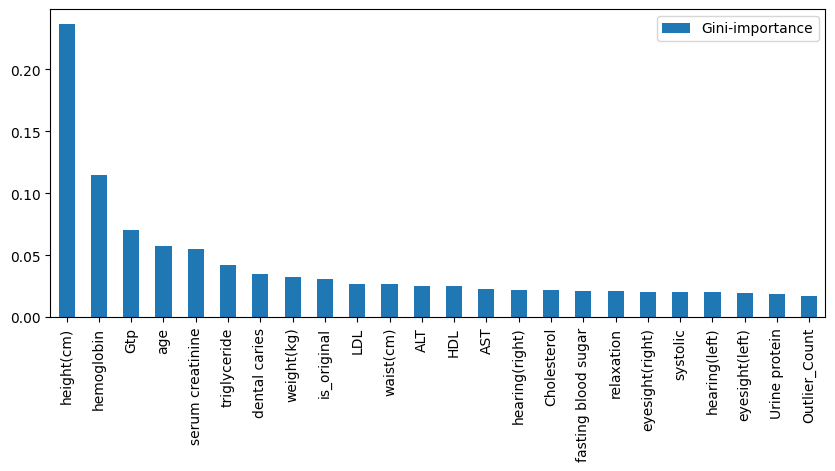

CPU times: user 1.44 s, sys: 215 ms, total: 1.65 s
Wall time: 610 ms


In [57]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline
# Creates a plot to visualize the most important features...

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_df[model_features].columns, xgboost_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=90, figsize=(10,4))
plt.show()